# Ground displacement detection using SAR Interferometry

## Introduction

This notebook showcases the use of the [Catalyst Ground Disaplacement](https://marketplace.up42.com/block/23de425c-7954-45fb-84c5-f75abe00e2d2) algorithm based on [Synthetic Aperture Radar](https://earthdata.nasa.gov/learn/backgrounders/what-is-sar) (SAR) Interferometry.

[Interferometry](https://en.wikipedia.org/wiki/Interferometry) is the analysis of physical phenomena based on the phase differences of the response to two superimposed electromagnetic waves sent across the region where the phenomena being studied occurs.

<center>
  <figure>  
    <img alt="Constructive interference of two waves" src="_assets/waves.png" title="Constructive interference"></img> 
      <figcaption>Constructive interference of two waves: in phase - 0° phase difference</figcaption>         
   </figure>
    
  <figure>  
    <img alt="Destructive interference of two waves" src="_assets/waves2.png" title="Constructive interference"></img> 
      <figcaption>Destructive interference of two waves: out of phase - 180° phase difference</figcaption>         
   </figure>    
</center>


In this case radar pulses generate electromagnetic waves that are sent from a satellite orbiting the Earth to the surface of the planet. The resulting [backscatter](https://en.wikipedia.org/wiki/Backscatter) allows to analyse the area being irradiated to significant detail.

Here we use this technique to study displacement of terrain. This has multiple applications from Landslide prediction to imminent structural failure detection of large man made structures like bridges and dams.


## The Rishi Ganga Valley 2021 Disaster 

In the morning of [February 7th 2021](https://www.abc.net.au/news/2021-02-08/himalayan-glacier-breaks-india-150-feared-dead-in-floods/13130866), part of a glacier in the higher regions of mount [Nanda Devi](https://en.wikipedia.org/wiki/Nanda_Devi) in the Himalayan range, located in the Indian state of Uttarakhand, collapsed dragging rocks and mud with it into the rivers down below in the Rishi Ganga valley. The sudden increse in volume in the rivers propeled huge floods that dragged everything in their path. One power plant got wiped out while other had partually collapsed.

<center>
  <figure>  
    <img alt="Debris all over the Dheuliganga dam" src="_assets/dheuliganga_powerplant_debris.jpeg" title="Debris all over the Dheuliganga dam"></img> 
      <figcaption>Accumulation of mud and other debris on the Dheuliganga river dam</figcaption>         
   </figure>
</center>  


Our goal is to use SAR Interferometry to predict the landslide by observing the motion of the ground as time passes. For that we are going to use two different images, both acquired **before** the landslide. The first image is **well before** the landslide and the second **just before** the landslide. We should be able to perceive the _accelerated_ motion as the tipping point of February 7th &mdash; when the landslide happened &mdash; is reached.

Let us now outline our procedure.

## Outline

We are going to:

 1. Get the UP42 Python SDK installed.
 2. Configure and authenticate with the UP42 API
 3. Perform a catalog search of images that obey the criteria cited above, i.e., one well before and one just ahead of the landslide.
 4. Configure and run the workflow.
 5. Briefly analyze the results.

## Install the Python SDK

The [UP42 Python SDK](https://sdk.up42.com) enables to quickly create an integration with the UP42 API using Python. For further information on using UP42 in general, and the API in particular, please consult the [documentation](https://sdk.up42.com).

The module is called `up42`. Python **>= 3.7** is **required**.

 1. Create a virtual environment.
```bash
 mkvirtualenv --python=$(which python3) up42-py
```
 2. Activate the environment.
```bash
 workon up42-py
```
 3. Install the module.
 ```bash
 pip install up42-py
 ```
 4. Install Jupyter Lab.
```bash
 pip install jupyterlab
 ```
 5. Done.
 
Now we can just import it.

In [1]:
import up42

## Authenticate with project ID and project key
The project API key and the project ID are read from a JSON file.
This file has the following structure:

```json
{
  "project_id": "<your-project-ID-here>",
  "project_api_key": "<your-api-key-here>"
}
```
To know how to obtain the project API key and project ID the please refer to the [documentation](https://docs.up42.com/developers/guides/introduction#project-variables).

In [2]:
from pathlib import Path

In [3]:
# Reading the credentials from proj_default.conf

project_config_file = Path.home().joinpath(".up42/proj_default.conf") 
up42.authenticate(cfg_file = project_config_file)

2021-05-25 18:27:25,638 - Got credentials from config file.
2021-05-25 18:27:26,611 - Authentication with UP42 successful!


## Use catalog search to look for suitable images

In our search for suitable images we need to pay attention to some parameters in order to obtain two images that can be meaningfully _interfereced_. We know that interferometry relies on the fact that the two waves are superimposed. To guarantee
that we need to make sure that:

 * They have the same orbit number so that they cover exactly the same region.
 * Possibly picked up by the same sensor.
 * The same orbit direction: ascending or descending.
 * Differ not too much in terms of acquistion date.
 
Another thing to keep in mind is that since we are working with phases and amplitudes we can simplify the analysis if we work with [Complex numbers](https://en.wikipedia.org/wiki/Complex_number) this way we have both phase and amplitude represented by a single number. The product we need to choose as data to be provided to the interferometry based ground displacement is called [Single Look Complex](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex) for the [Sentinel 1](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-1) SAR based Earth Observation satellite.

But we will specify that later, right now we just need to perform the search for the images, and, since the above criteria cannot, currently, be specified as searh critaria, we search for all images that cover the given AOI completely.

### Read the AOI

We have the AOI in an external file. Let's read it. 

In [4]:
aoi =  up42.read_vector_file("data/rishi_ganga_valley.geojson")

### Initialize the catalog

In [5]:
my_catalog = up42.initialize_catalog()

### Build the search parameters (STAC query)

The catalog interface obeys the [Spatio Temporal Asset Catalog](https://stacspec.org/STAC-api.html) specification. 

In [6]:
search_params = my_catalog.construct_parameters(geometry = aoi, 
                                                start_date = "2021-01-15",
                                                end_date = "2021-02-05",
                                                sortby = "acquisitionDate",
                                                ascending = False,
                                                sensors = [ "sentinel1" ],
                                                limit = 100)

In [7]:
search_params

{'datetime': '2021-01-15T00:00:00Z/2021-02-05T23:59:59Z',
 'intersects': {'type': 'Polygon',
  'coordinates': (((79.823715, 30.296131),
    (79.80487, 30.491821),
    (79.579599, 30.488781),
    (79.585253, 30.30102),
    (79.823715, 30.296131)),)},
 'limit': 100,
 'query': {'dataBlock': {'in': ['sobloo-s1-grd-fullscene',
    'sobloo-s1-grd-aoiclipped',
    'sobloo-s1-slc-fullscene']}},
 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}

Inspecting the data blocks being considered.

In [8]:
data_block_names = search_params["query"]["dataBlock"]["in"]  

In [9]:
data_block_names

['sobloo-s1-grd-fullscene',
 'sobloo-s1-grd-aoiclipped',
 'sobloo-s1-slc-fullscene']

As we can see we are looking for data that not only is provided by the SLC block. Let us remove all other Sentinel 1 related blocks but SLC.

In [10]:
from re import compile, match

re_slc = compile(".*-slc-.*")

In [11]:
search_params["query"]["dataBlock"]["in"] = [b for b in search_params["query"]["dataBlock"]["in"] if re_slc.match(b)]
search_params

{'datetime': '2021-01-15T00:00:00Z/2021-02-05T23:59:59Z',
 'intersects': {'type': 'Polygon',
  'coordinates': (((79.823715, 30.296131),
    (79.80487, 30.491821),
    (79.579599, 30.488781),
    (79.585253, 30.30102),
    (79.823715, 30.296131)),)},
 'limit': 100,
 'query': {'dataBlock': {'in': ['sobloo-s1-slc-fullscene']}},
 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}

### Launch the search

In [12]:
search_results = my_catalog.search(search_parameters = search_params);

2021-05-25 18:27:26,826 - Searching catalog with search_parameters: {'datetime': '2021-01-15T00:00:00Z/2021-02-05T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((79.823715, 30.296131), (79.80487, 30.491821), (79.579599, 30.488781), (79.585253, 30.30102), (79.823715, 30.296131)),)}, 'limit': 100, 'query': {'dataBlock': {'in': ['sobloo-s1-slc-fullscene']}}, 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}
2021-05-25 18:27:28,079 - 10 results returned.


In [13]:
search_results

,geometry,id,acquisitionDate,constellation,collection,providerName,blockNames,cloudCoverage,up42:usageType,providerProperties,sceneId,resolution,deliveryTime,producer
0,"POLYGON ((77.78904 28.70102, 80.34694 29.10940...",9c13868a-9ed4-4c52-ba29-c14f2950eeea,2021-02-03T12:47:22Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1612356442812, 'uid': '9c13868a-...",S1A_IW_SLC__1SDV_20210203T124722_20210203T1247...,10.0,MINUTES,ESA
1,"POLYGON ((79.97137 28.91909, 80.33391 30.54385...",f8377125-ee75-43ff-9ffb-b52d8e170ba3,2021-01-30T00:43:41Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1611967421690, 'uid': 'f8377125-...",S1A_IW_SLC__1SDV_20210130T004341_20210130T0044...,10.0,MINUTES,ESA
2,"POLYGON ((79.83602 28.99797, 82.38296 29.40199...",2576e088-de28-4be0-a817-338e7c91e2cb,2021-01-29T12:39:14Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1611923954119, 'uid': '2576e088-...",S1A_IW_SLC__1SDV_20210129T123914_20210129T1239...,10.0,MINUTES,ESA
3,"POLYGON ((81.92436 28.52978, 82.28534 30.15472...",2b2c2936-7a8e-4ca0-b060-330b1c836b5d,2021-01-25T00:35:34Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1611534934616, 'uid': '2b2c2936-...",S1A_IW_SLC__1SDV_20210125T003534_20210125T0036...,10.0,MINUTES,ESA
4,"POLYGON ((82.20346 30.03545, 82.58124 31.71641...",8fe00f25-73dc-4631-9cfc-eb9bf0dc5b32,2021-01-25T00:35:08Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1611534908847, 'uid': '8fe00f25-...",S1A_IW_SLC__1SDV_20210125T003508_20210125T0035...,10.0,MINUTES,ESA
5,"POLYGON ((77.79016 28.70118, 80.34802 29.10953...",f013c628-42ed-4cd5-9b92-4518fd0357b6,2021-01-22T12:47:23Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1611319643175, 'uid': 'f013c628-...",S1A_IW_SLC__1SDV_20210122T124723_20210122T1247...,10.0,MINUTES,ESA
6,"POLYGON ((79.97263 28.91842, 80.33521 30.54318...",ad657c21-2b0c-4dfa-8e62-f4e89d9da09c,2021-01-18T00:43:42Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1610930622009, 'uid': 'ad657c21-...",S1A_IW_SLC__1SDV_20210118T004342_20210118T0044...,10.0,MINUTES,ESA
7,"POLYGON ((79.83591 28.99825, 82.38282 29.40231...",cbdf16ee-e39e-4e16-892d-a232903e363c,2021-01-17T12:39:14Z,Sentinel-1,Sentinel-1,sobloo-radar,[sobloo-s1-slc-fullscene],None,[ANALYTICS],"{'timeStamp': 1610887154441, 'uid': 'cbdf16ee-...",S1A_IW_SLC__1SDV_20210117T123914_20210117T1239...,10.0,MINUTES,ESA


Now let us get the columns of the data frame.

In [14]:
[c for c in search_results.columns]

['geometry',
 'id',
 'acquisitionDate',
 'constellation',
 'collection',
 'providerName',
 'blockNames',
 'cloudCoverage',
 'up42:usageType',
 'providerProperties',
 'sceneId',
 'resolution',
 'deliveryTime',
 'producer']

We compose the result list from the sceneIds, relative orbit number and direction. We know that these are the criteria to consider when selecting the images. 

In [15]:
rl = [(sid, acq_date, rp["orbit"]["relativeNumber"], rp["orbit"]["direction"]) for sid, acq_date, rp in zip(search_results.sceneId, search_results.acquisitionDate, search_results.providerProperties)]

Converting into a data frame. 

In [16]:
from pandas import DataFrame as df

In [17]:
scene_list = df(rl, columns = ["sceneId", "acquisitionDate", "orbitRelativeNumber", "direction"])

In [18]:
scene_list[scene_list.direction == "ASCENDING"]

,sceneId,acquisitionDate,orbitRelativeNumber,direction
0,S1A_IW_SLC__1SDV_20210203T124722_20210203T1247...,2021-02-03T12:47:22Z,129,ASCENDING
2,S1A_IW_SLC__1SDV_20210129T123914_20210129T1239...,2021-01-29T12:39:14Z,56,ASCENDING
5,S1A_IW_SLC__1SDV_20210122T124723_20210122T1247...,2021-01-22T12:47:23Z,129,ASCENDING
7,S1A_IW_SLC__1SDV_20210117T123914_20210117T1239...,2021-01-17T12:39:14Z,56,ASCENDING


In [19]:
scene_list[scene_list.direction == "DESCENDING"]

,sceneId,acquisitionDate,orbitRelativeNumber,direction
1,S1A_IW_SLC__1SDV_20210130T004341_20210130T0044...,2021-01-30T00:43:41Z,63,DESCENDING
3,S1A_IW_SLC__1SDV_20210125T003534_20210125T0036...,2021-01-25T00:35:34Z,165,DESCENDING
4,S1A_IW_SLC__1SDV_20210125T003508_20210125T0035...,2021-01-25T00:35:08Z,165,DESCENDING
6,S1A_IW_SLC__1SDV_20210118T004342_20210118T0044...,2021-01-18T00:43:42Z,63,DESCENDING


We can see that it is the images from February 3rd and January 22nd that fit our criteria, recalling:

 * Same relative orbit number.
 * Same direction.
 * One of the acquisition dates is just before the landslide (Feb 7th 2021).

Saving the two scene IDs in a list to be used when configuring the job.    

In [20]:
final_scene_id_list = scene_list.sceneId[scene_list.orbitRelativeNumber == 129].to_list()
final_scene_id_list

['S1A_IW_SLC__1SDV_20210203T124722_20210203T124749_036426_0446AB_FD12',
 'S1A_IW_SLC__1SDV_20210122T124723_20210122T124750_036251_04409C_E11A']

Now we have what we need to configure the job:

 1. AOI
 2. Chosen scenes

## Creating the workflow

We're going to use a previously created workflow. The workflow can also be created here. This is just for brevity. You can do it either way. We are going to now set the workflow ID that corresponds to a previously created workflow.

In [21]:
insar_workflow_id = "e87de28d-91c6-48ea-9931-609616729a9d"

Now the workflow is initialized.

In [22]:
insar_workflow = up42.initialize_workflow(workflow_id = insar_workflow_id)

2021-05-25 18:27:29,851 - Initialized Workflow(name: S1 L1C GRD full scene for InSAR, workflow_id: e87de28d-91c6-48ea-9931-609616729a9d, description: , createdAt: 2021-05-20T17:23:37.906274Z, project_id: 5ea6a20d-4fa9-42a1-8e29-f2d9b27b0097, workflow_tasks: {'sobloo-s1-slc-fullscene:1': '2.2.4', 'catalystpro-insstack:1': '1.32.1-public'}


### List the workflow tasks

For completeness we list the workflow tasks explicitly here.

In [23]:
insar_workflow.get_workflow_tasks(basic = True)

2021-05-25 18:27:30,442 - Got 2 tasks/blocks in workflow e87de28d-91c6-48ea-9931-609616729a9d.


{'sobloo-s1-slc-fullscene:1': '2.2.4',
 'catalystpro-insstack:1': '1.32.1-public'}

As you can see we have both the Sentinel 1 SLC and the Catalyst InSAR ground displacement analytics block.

### Get the job parameters _template_
We need to find out what parameters are accepted by this workflow. It includes **all** the parameters for **each** block in the workflow.

In [24]:
insar_workflow_params_info = insar_workflow.get_parameters_info()

2021-05-25 18:27:31,010 - Got 2 tasks/blocks in workflow e87de28d-91c6-48ea-9931-609616729a9d.


In [25]:
insar_workflow_params_info

{'sobloo-s1-slc-fullscene:1': {'ids': {'type': 'array', 'default': None},
  'bbox': {'type': 'array', 'default': None},
  'time': {'type': 'dateRange',
   'default': '2018-01-01T00:00:00+00:00/2021-12-31T23:59:59+00:00'},
  'limit': {'type': 'integer', 'default': 1, 'minimum': 1},
  'contains': {'type': 'geometry'},
  'intersects': {'type': 'geometry'},
  'time_series': {'type': 'array', 'default': None},
  'mission_code': {'type': 'string', 'default': None},
  'orbit_direction': {'type': 'string', 'default': None},
  'acquisition_mode': {'type': 'string', 'default': None},
  'orbit_relative_number': {'type': 'integer', 'default': None}},
 'catalystpro-insstack:1': {'aoi_bbox': {'type': 'array', 'default': None},
  'aoi_geojson': {'type': 'geometry', 'default': None}}}

## Create the job parameters

We need to **repeat** the AOI given to the data block for the processing block also. Let us build the job parameters. We set the scene IDs using the list we created above.

In [26]:
insar_job_params = insar_workflow.construct_parameters(geometry = aoi["features"][0]["geometry"], 
                                                       geometry_operation = "intersects", 
                                                       scene_ids = final_scene_id_list)
insar_job_params["catalystpro-insstack:1"].update(aoi_geojson = aoi["features"][0]["geometry"])

In [27]:
insar_job_params

{'sobloo-s1-slc-fullscene:1': {'limit': 2,
  'ids': ['S1A_IW_SLC__1SDV_20210203T124722_20210203T124749_036426_0446AB_FD12',
   'S1A_IW_SLC__1SDV_20210122T124723_20210122T124750_036251_04409C_E11A'],
  'intersects': {'type': 'Polygon',
   'coordinates': (((79.823715, 30.296131),
     (79.80487, 30.491821),
     (79.579599, 30.488781),
     (79.585253, 30.30102),
     (79.823715, 30.296131)),)}},
 'catalystpro-insstack:1': {'aoi_geojson': {'type': 'Polygon',
   'coordinates': (((79.823715, 30.296131),
     (79.80487, 30.491821),
     (79.579599, 30.488781),
     (79.585253, 30.30102),
     (79.823715, 30.296131)),)}}}

## Run the job

Now we have all we need to launch the job. Before we launch it we estimate the cost.

In [28]:
insar_workflow.estimate_job(input_parameters = insar_job_params)

2021-05-25 18:27:38,579 - Estimated: 2-2067 Credits, Duration: 0-0 min.


{'sobloo-s1-slc-fullscene:1': {'blockConsumption': {'resources': {'unit': 'MEGABYTE',
    'min': 14806,
    'max': 14954.06},
   'credit': {'min': 0, 'max': 0}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}},
 'catalystpro-insstack:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0,
    'max': 412.907069},
   'credit': {'min': 0, 'max': 2065}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}}}

The total estimated cost is up to 2067 credits (~ 20 EUR).

In [29]:
insar_job = insar_workflow.run_job(input_parameters = insar_job_params, 
                                name="Rishi Ganga Valley 2021 Landslide (SDK)", 
                                track_status = True)

2021-05-25 18:27:38,588 - Selected input_parameters: {'sobloo-s1-slc-fullscene:1': {'limit': 2, 'ids': ['S1A_IW_SLC__1SDV_20210203T124722_20210203T124749_036426_0446AB_FD12', 'S1A_IW_SLC__1SDV_20210122T124723_20210122T124750_036251_04409C_E11A'], 'intersects': {'type': 'Polygon', 'coordinates': (((79.823715, 30.296131), (79.80487, 30.491821), (79.579599, 30.488781), (79.585253, 30.30102), (79.823715, 30.296131)),)}}, 'catalystpro-insstack:1': {'aoi_geojson': {'type': 'Polygon', 'coordinates': (((79.823715, 30.296131), (79.80487, 30.491821), (79.579599, 30.488781), (79.585253, 30.30102), (79.823715, 30.296131)),)}}}
2021-05-25 18:27:41,903 - Created and running new job: 48ae9c19-d990-4fe9-8b6d-8f9350b27cdb.
2021-05-25 18:27:42,376 - Tracking job status continuously, reporting every 30 seconds...
2021-05-25 18:28:16,108 - Job is RUNNING! - 48ae9c19-d990-4fe9-8b6d-8f9350b27cdb
2021-05-25 18:28:49,086 - Job is RUNNING! - 48ae9c19-d990-4fe9-8b6d-8f9350b27cdb
2021-05-25 18:29:22,151 - Job is

### Downloading the results

In [30]:
my_path = Path.home().joinpath("up42/catalyst-demo/results-rishi-ganga")

In [31]:
insar_job_results  = insar_job.download_results(output_directory = my_path)

2021-05-25 19:45:02,510 - Downloading results of job 48ae9c19-d990-4fe9-8b6d-8f9350b27cdb
2021-05-25 19:45:02,512 - Download directory: /Users/appa/up42/catalyst-demo/results-rishi-ganga
89353it [00:00, 304726.97it/s]
2021-05-25 19:45:18,050 - Download successful of 11 files to output_directory '/Users/appa/up42/catalyst-demo/results-rishi-ganga': ['S1A_IW_SLC__1SDV_20210203T124722_20210203T124749_036426_0446AB_FD12.tif', 'S1A_IW_SLC__1SDV_20210203T124722_20210203T124749_036426_0446AB_FD12.tif.pox', 'cumulative_displacement_stack_Statistics.tif.pox', 'cumulative_displacement_stack_Coherences.tif.pox', 'cumulative_displacement_stack.tif.pox', 'velocity_stack.tif.pox', 'velocity_stack.tif', 'data.json', 'cumulative_displacement_stack.tif', 'cumulative_displacement_stack_Statistics.tif', 'cumulative_displacement_stack_Coherences.tif']


In [32]:
[f for f in my_path.glob("*")]

[PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/S1A_IW_SLC__1SDV_20210203T124722_20210203T124749_036426_0446AB_FD12.tif'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/S1A_IW_SLC__1SDV_20210203T124722_20210203T124749_036426_0446AB_FD12.tif.pox'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/cumulative_displacement_stack_Statistics.tif.pox'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/.DS_Store'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/cumulative_displacement_stack_Coherences.tif.pox'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/cumulative_displacement_stack.tif.pox'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/velocity_stack.tif.pox'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/velocity_stack.tif'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-ganga/data.json'),
 PosixPath('/Users/appa/up42/catalyst-demo/results-rishi-gan

## Ploting the results

We get the last file first and plot it.

In [33]:
import matplotlib as mpl
from matplotlib import pyplot
import rasterio as rio

displacement_stack_raster = insar_job_results[-3] 

We set the no data value to -32768 to get rid of image _artifacts_. And open the file.

In [34]:
with rio.open(displacement_stack_raster, 'r+') as ds:
    ds.nodata = -32768

displacement_stack_raster = rio.open(displacement_stack_raster)

We set the axes and the size of the plot as well as the color map to be used in the plot. We use a Red to Green colormap.

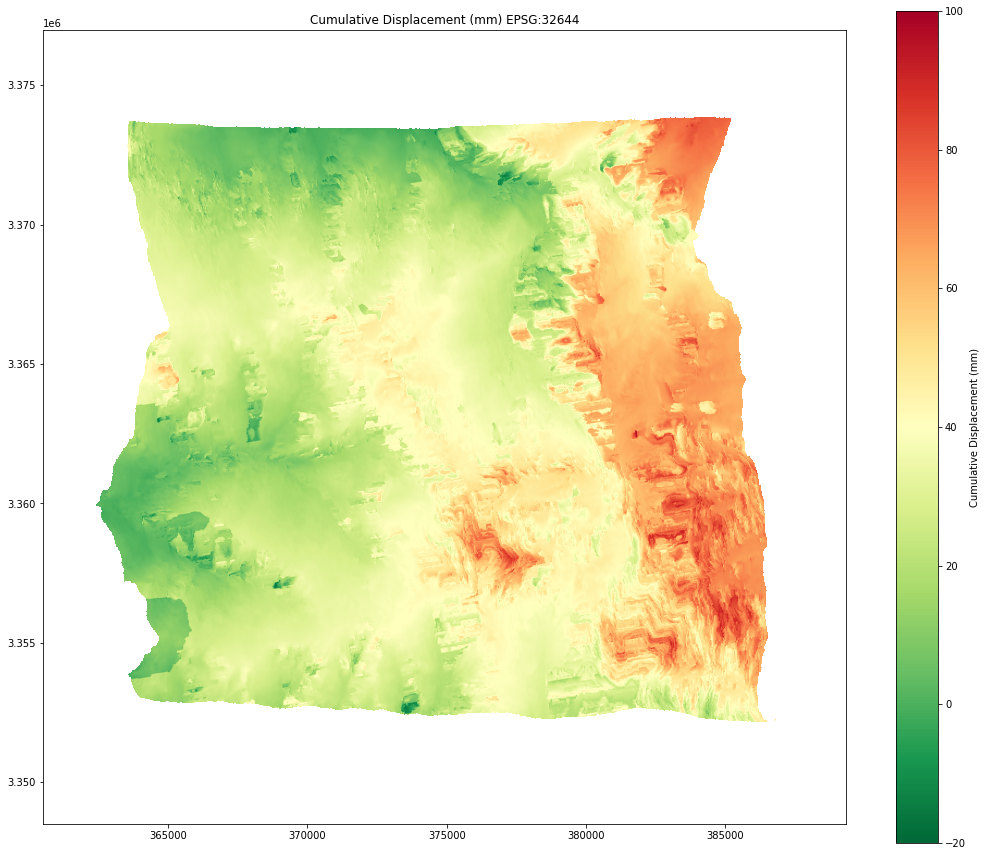

<AxesSubplot:title={'center':'Cumulative Displacement (mm) EPSG:32644'}>

In [35]:
# Axes and plot size.
fig, ax = mpl.pyplot.subplots(1, figsize = (18,18))

# Color map.
color_map = mpl.cm.get_cmap('RdYlGn')
color_map = color_map.reversed()
pyplot.colorbar(pyplot.imshow(displacement_stack_raster.read(1), 
                              cmap = color_map, vmin = -20, vmax =100),
                              shrink = 0.85,
                              label = "Cumulative Displacement (mm)")
pyplot.title("Cumulative Displacement (mm) EPSG:32644")
rio.plot.show(displacement_stack_raster, cmap = color_map)

### What comes next
 
The plot shows that ground deformation was visible before the landslide occurred, showing that SAR Interferometry (InSAR) can effectively detect ground movement leading up to catastrophic failures.

We can extend this workflow by using a longer time series of images corresponding to the months, weeks, and days leading up to the failure, to assess if an acceleration in ground deformation can be detected.